In [1]:
import os
import scanpy as sc
import anndata as ad
from bbknn import bbknn
import numpy as np

/Users/nv4/miniforge3/envs/Junho2024X86/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Merge adata objects. 

In [14]:

# === PARAMETERS ===
folder_path = "/Users/nv4/Downloads/atlas_dataset/"
# os.listdir(folder_path)[0:6]
min_genes = 500
min_counts = 1000
max_genes = 700

# === STEP 1. Read and QC each dataset ===
adatas = []
# for fname in os.listdir(folder_path)[0:4]:
#     if fname.endswith(".h5ad"):
#         fpath = os.path.join(folder_path, fname)
#         print(f"Reading {fname}...")
        
#         adata = sc.read_h5ad(fpath)
        
#         # Basic QC filters (optional, can adjust later)
#         sc.pp.filter_cells(adata, min_genes=min_genes)
#         # adata = adata[adata.obs['n_counts'] >= min_counts, :]
#         # adata = adata[adata.obs['n_genes'] <= max_genes, :]
        
#         adatas.append(adata)


# # === STEP 2. Concatenate all into one AnnData ===
# adata = ad.concat(adatas, join="outer", label="Dataset", fill_value=0)
# # AnnData object with n_obs × n_vars = 127360 × 36601
# # AnnData object with n_obs × n_vars = 126952 × 36601 --> filtering step needed!!
# print(adata)

for fname in os.listdir(folder_path)[0:9]:
    if fname.endswith(".h5ad"):
        fpath = os.path.join(folder_path, fname)
        print(f"\nReading {fname}...")
        
        adata = sc.read_h5ad(fpath)
        
        # Compute QC metrics if missing
        if "n_genes" not in adata.obs.columns:
            adata.obs["n_genes"] = (adata.X > 0).sum(axis=1).A1 if not isinstance(adata.X, np.ndarray) else (adata.X > 0).sum(axis=1)
        if "n_counts" not in adata.obs.columns:
            adata.obs["n_counts"] = adata.X.sum(axis=1).A1 if not isinstance(adata.X, np.ndarray) else adata.X.sum(axis=1)
        
        n_total = adata.n_obs
        n_low_counts = (adata.obs["n_counts"] < min_counts).sum()
        n_low_genes = (adata.obs["n_genes"] < min_genes).sum()
        n_high_genes = (adata.obs["n_genes"] > max_genes).sum()
        
        print(f" Total cells: {n_total}")
        print(f"Removing (< {min_counts} counts): {n_low_counts}")
        print(f"Removing (< {min_genes} genes): {n_low_genes}")
        print(f"Removing (> {max_genes} genes): {n_high_genes}")

        sc.pp.filter_cells(adata, min_genes=min_genes)
        adata = adata[adata.obs['n_counts'] >= min_counts, :]
        adata = adata[adata.obs['n_genes'] <= max_genes, :]
        
        adatas.append(adata)

# === STEP 2. Concatenate without filtering ===
adata = ad.concat(adatas, join="outer", label="dataset", fill_value=0)

print("\nCombined AnnData:", adata)


Reading mel_uv_GSE139829.h5ad...
 Total cells: 94584
Removing (< 1000 counts): 207
Removing (< 500 genes): 357
Removing (> 700 genes): 84610

Reading mel_uv_GSE176029.h5ad...
 Total cells: 8922
Removing (< 1000 counts): 13
Removing (< 500 genes): 1
Removing (> 700 genes): 8478

Reading hcc_ihcca_GSE125449.h5ad...
 Total cells: 9272
Removing (< 1000 counts): 364
Removing (< 500 genes): 46
Removing (> 700 genes): 7380

Reading pdac_GSE154778.h5ad...
 Total cells: 14582
Removing (< 1000 counts): 4
Removing (< 500 genes): 4
Removing (> 700 genes): 14383

Reading lu_adc_GSE131907.h5ad...
 Total cells: 178644
Removing (< 1000 counts): 731
Removing (< 500 genes): 540
Removing (> 700 genes): 157643

Reading nbl_EGAD0000100637.h5ad...
 Total cells: 6021
Removing (< 1000 counts): 9
Removing (< 500 genes): 5
Removing (> 700 genes): 5406

Reading intestine_gca.h5ad...
 Total cells: 376004
Removing (< 1000 counts): 1081
Removing (< 500 genes): 308
Removing (> 700 genes): 345838

Reading ov_pan_blu

In [12]:
df = adata.obs
print(df["Sample"].unique())

['GSM4147093', 'GSM4147097', 'GSM4147095', 'GSM4147098', 'GSM4147099', ..., 'S12_P07_LCP30', 'S16_P10_LCP18', 'S19_P11_LCP39', 'S20_P12_LCP35', 'S21_P13_LCP37']
Length: 30
Categories (30, object): ['GSM4147091', 'GSM4147092', 'GSM4147093', 'GSM4147094', ..., 'S355_P13_LCP42', 'S358_P16_LCP46', 'S364_P21_LCP65', 'S365_P22_LCP66']


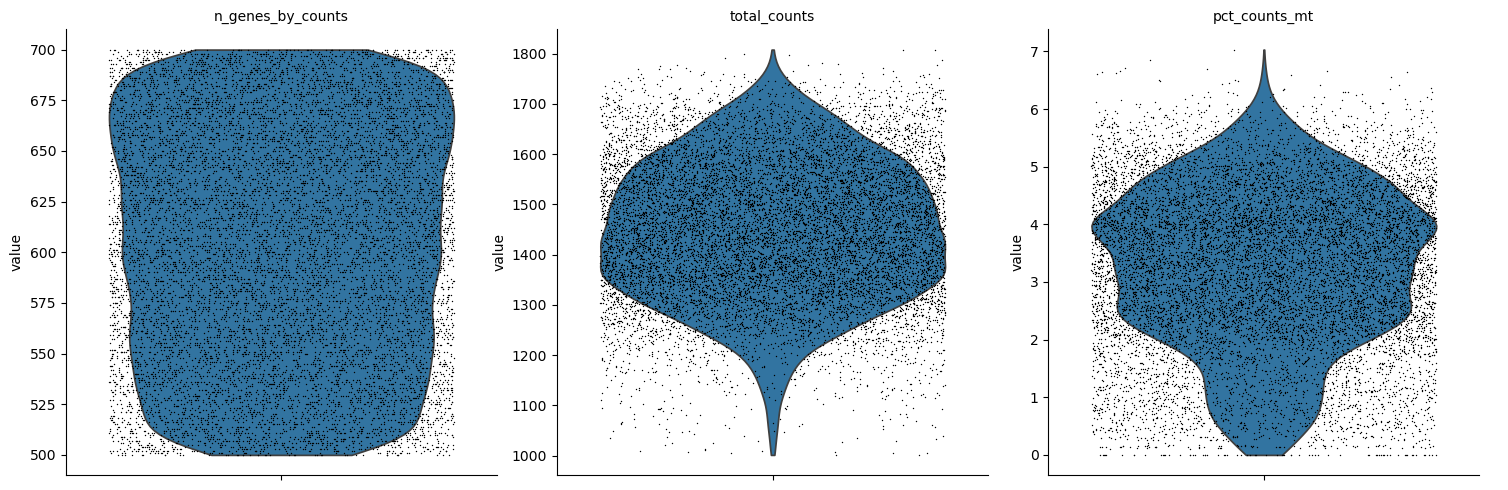

In [8]:
# mitochondrial genes, "MT-" for human, "Mt-" for mouse
adata.var["mt"] = adata.var_names.str.startswith("MT-")
# ribosomal genes
adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))
# hemoglobin genes
adata.var["hb"] = adata.var_names.str.contains("^HB[^(P)]")

sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt", "ribo", "hb"], inplace=True, log1p=True
)

sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True,
)

/Users/nv4/miniforge3/envs/Junho2024X86/lib/python3.9/site-packages/pandas/core/util/hashing.py:330: RuntimeWarning: invalid value encountered in cast
  vals.astype(str).astype(object), hash_key, encoding
/Users/nv4/miniforge3/envs/Junho2024X86/lib/python3.9/site-packages/pandas/core/util/hashing.py:330: RuntimeWarning: invalid value encountered in cast
  vals.astype(str).astype(object), hash_key, encoding
/Users/nv4/miniforge3/envs/Junho2024X86/lib/python3.9/site-packages/pandas/core/util/hashing.py:330: RuntimeWarning: invalid value encountered in cast
  vals.astype(str).astype(object), hash_key, encoding
/Users/nv4/miniforge3/envs/Junho2024X86/lib/python3.9/site-packages/pandas/core/util/hashing.py:330: RuntimeWarning: invalid value encountered in cast
  vals.astype(str).astype(object), hash_key, encoding
/Users/nv4/miniforge3/envs/Junho2024X86/lib/python3.9/site-packages/pandas/core/util/hashing.py:330: RuntimeWarning: invalid value encountered in cast
  vals.astype(str).astype(obj

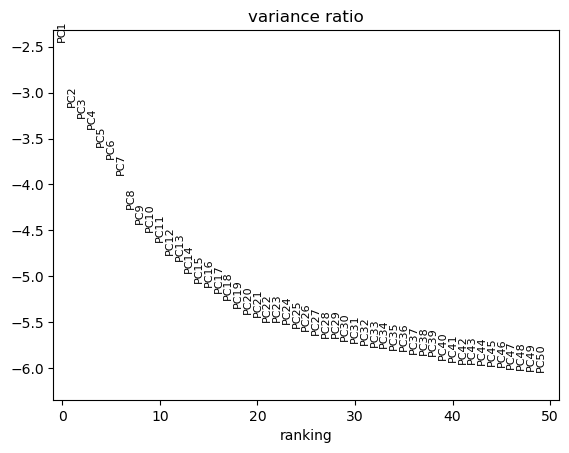

In [16]:
# Error because one dataset comes from a single sample. 
sc.pp.highly_variable_genes(adata, 
                            n_top_genes=2000, 
                            batch_key="Dataset") # Dataset or sample?
sc.tl.pca(adata)
sc.pl.pca_variance_ratio(adata, n_pcs=50, log=True)

In [17]:
sc.pp.neighbors(adata)
sc.tl.umap(adata)


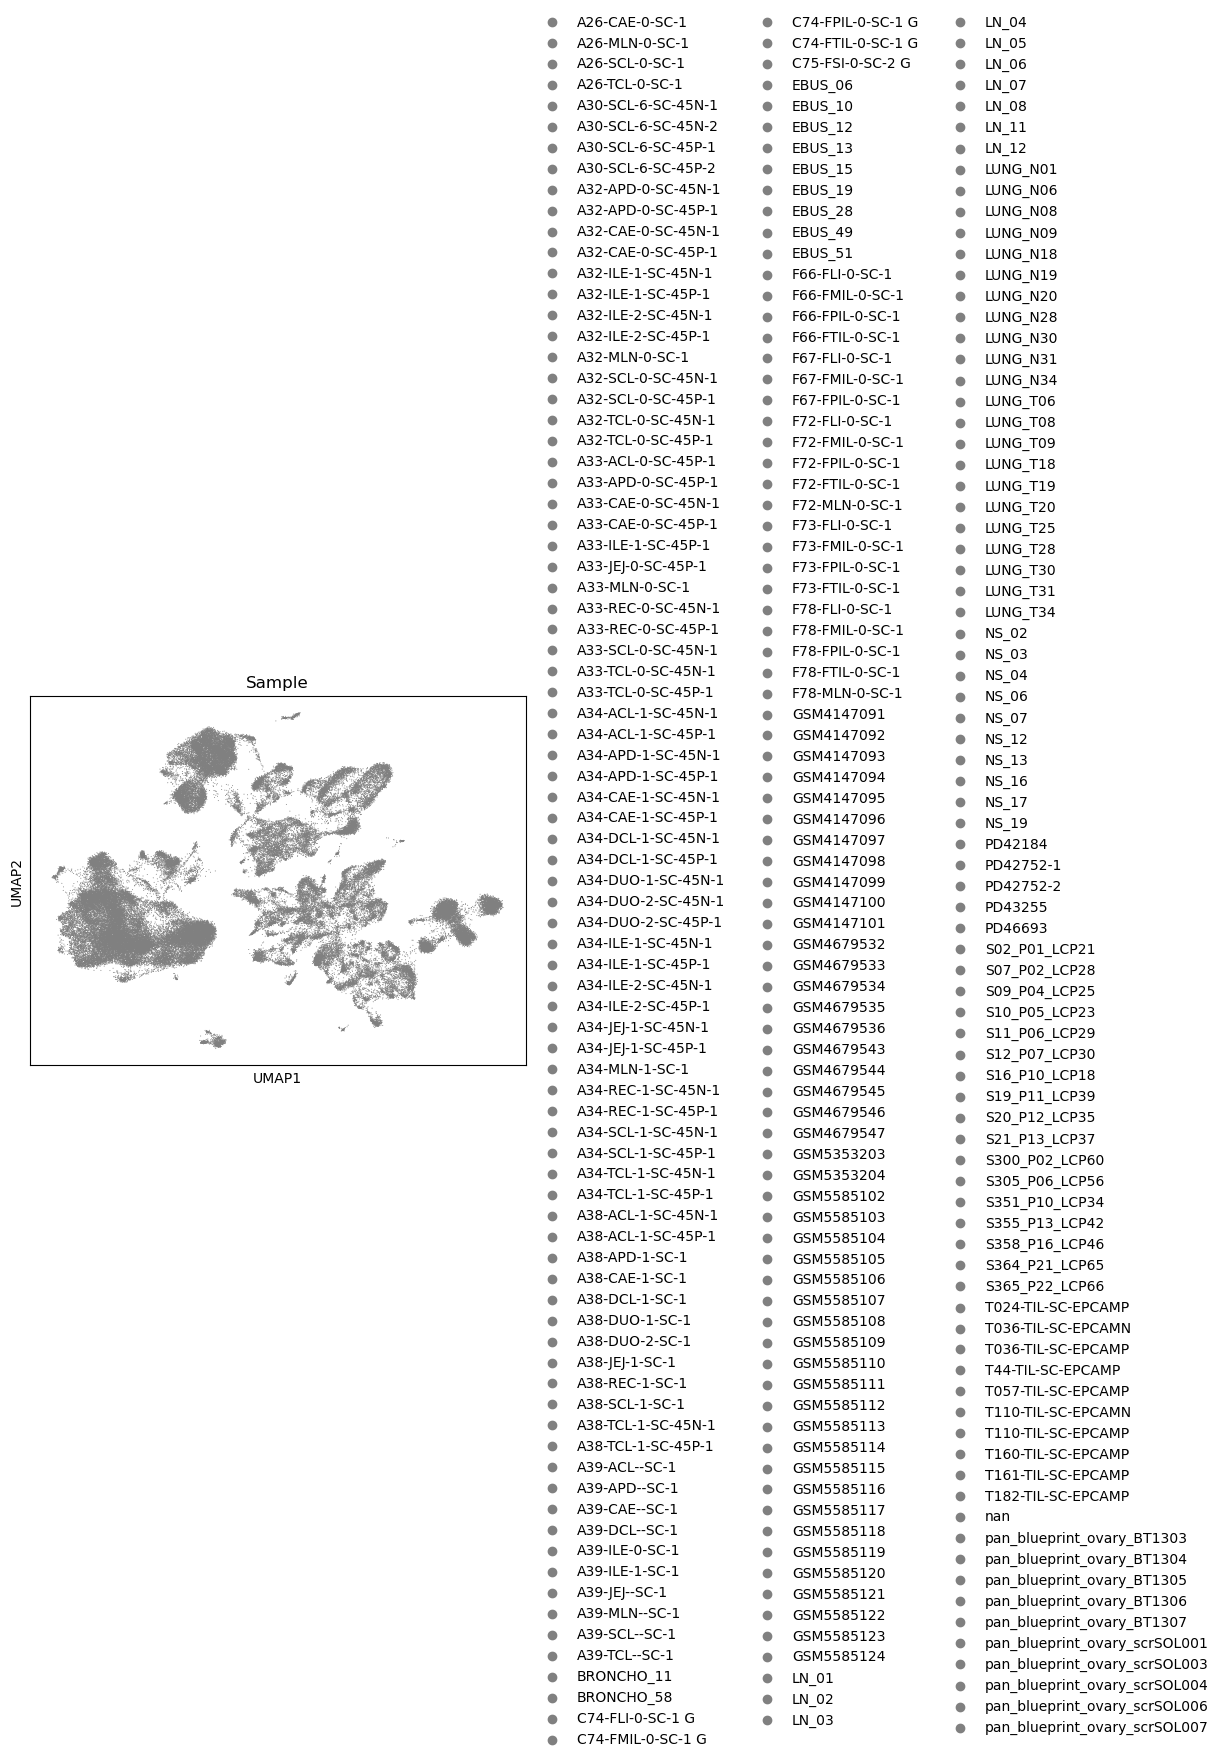

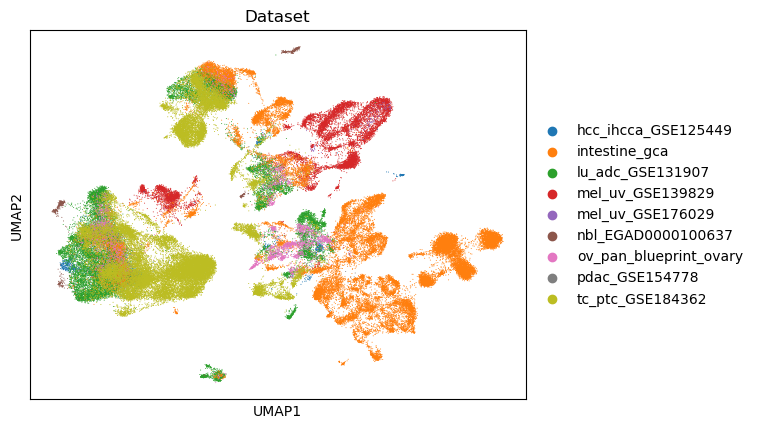

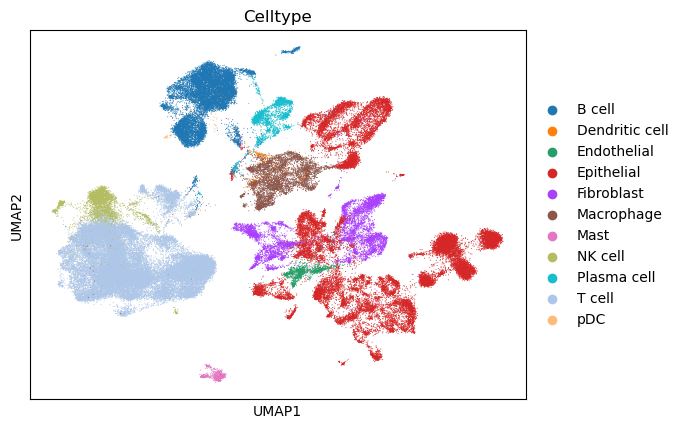

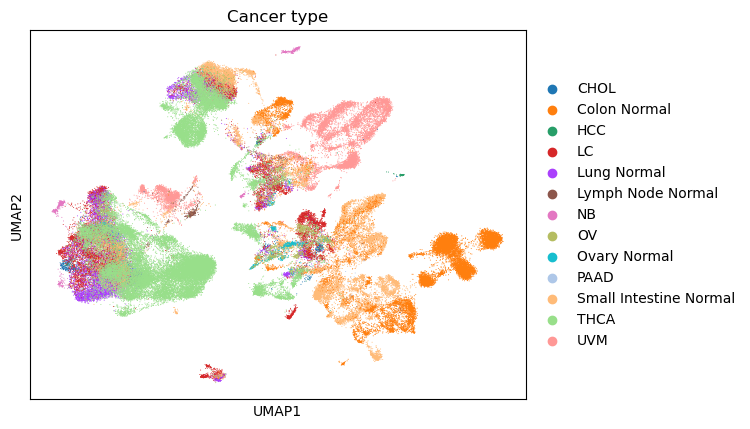

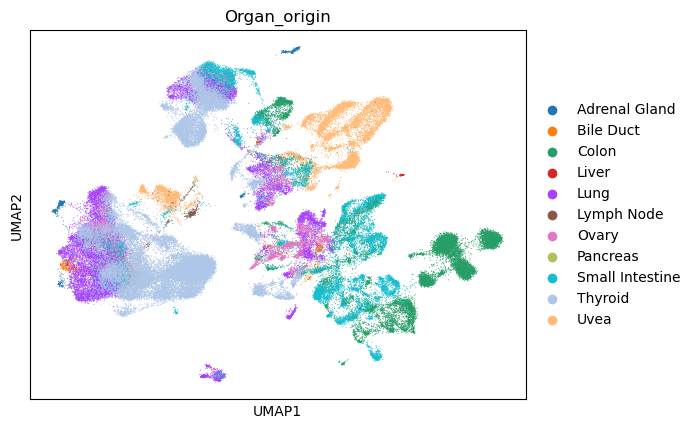

In [18]:
sc.pl.umap(
    adata,
    color="Sample",
    # Setting a smaller point size to get prevent overlap
    size=2,
)

sc.pl.umap(
    adata,
    color="Dataset",
    # Setting a smaller point size to get prevent overlap
    size=2,
)

sc.pl.umap(
    adata,
    color="Celltype",
    # Setting a smaller point size to get prevent overlap
    size=2,
)

sc.pl.umap(
    adata,
    color="Cancer type",
    # Setting a smaller point size to get prevent overlap
    size=2,
)

sc.pl.umap(
    adata,
    color="Organ_origin",
    # Setting a smaller point size to get prevent overlap
    size=2,
)

/Users/nv4/miniforge3/envs/Junho2024X86/lib/python3.9/site-packages/pandas/core/util/hashing.py:330: RuntimeWarning: invalid value encountered in cast
  vals.astype(str).astype(object), hash_key, encoding
/Users/nv4/miniforge3/envs/Junho2024X86/lib/python3.9/site-packages/pandas/core/util/hashing.py:330: RuntimeWarning: invalid value encountered in cast
  vals.astype(str).astype(object), hash_key, encoding
/Users/nv4/miniforge3/envs/Junho2024X86/lib/python3.9/site-packages/pandas/core/util/hashing.py:330: RuntimeWarning: invalid value encountered in cast
  vals.astype(str).astype(object), hash_key, encoding
/Users/nv4/miniforge3/envs/Junho2024X86/lib/python3.9/site-packages/pandas/core/util/hashing.py:330: RuntimeWarning: invalid value encountered in cast
  vals.astype(str).astype(object), hash_key, encoding
/Users/nv4/miniforge3/envs/Junho2024X86/lib/python3.9/site-packages/pandas/core/util/hashing.py:330: RuntimeWarning: invalid value encountered in cast
  vals.astype(str).astype(obj

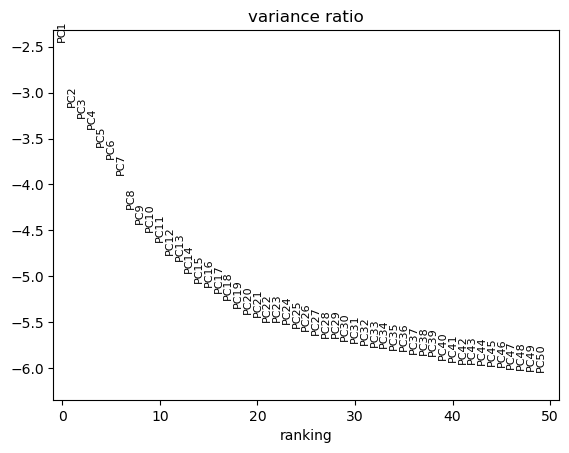

ValueError: Not all batches have at least `neighbors_within_batch` cells in them.

In [19]:
%%time
sc.pp.highly_variable_genes(adata, n_top_genes=2000, batch_key="Dataset") # Dataset or sample?
sc.tl.pca(adata)
sc.pl.pca_variance_ratio(adata, n_pcs=50, log=True)
bbknn(adata,batch_key='Sample')

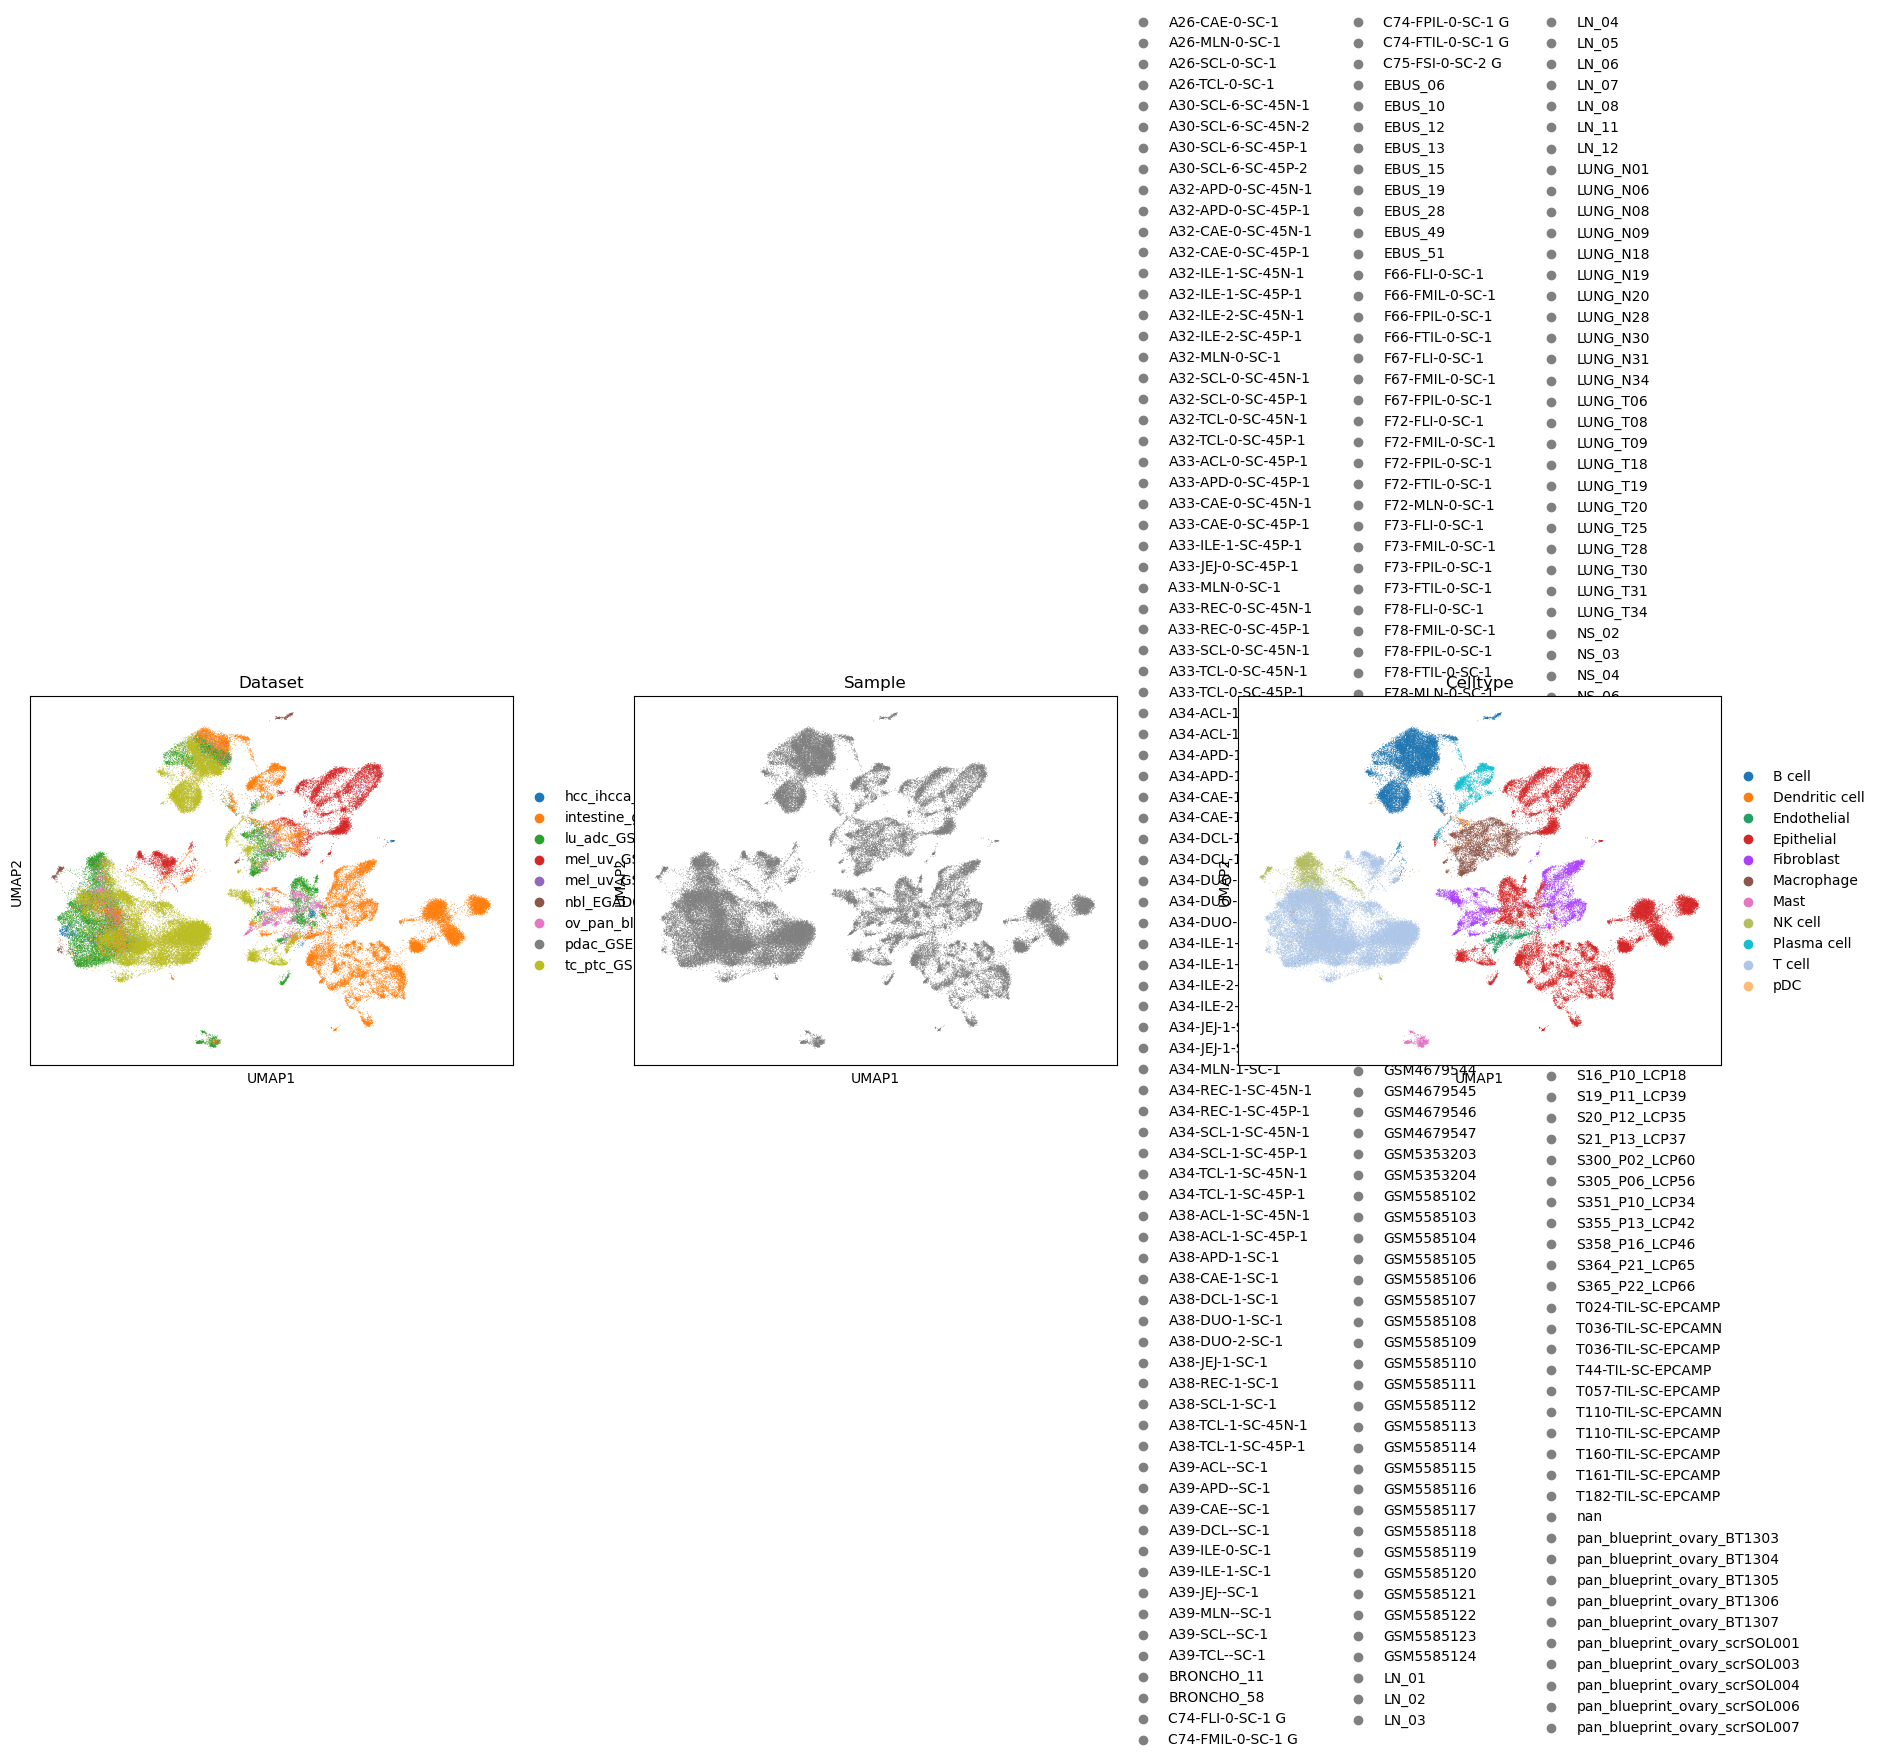

In [20]:
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.pl.umap(adata, color=["Dataset", "Sample", "Celltype"])